In [1]:
import pandas as pd
df = pd.read_csv('raw_data.csv')
df.tail(3)

,recorded,RADON_SHORT_TERM_AVG Bq/m3,PM2_5 μg/m3,CO2 ppm,HUMIDITY %,TEMP °C,VOC ppb,PRESSURE hPa,PM1 μg/m3
96344,2025-03-09T10:01:47,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96345,2025-03-09T10:01:49,NaN,NaN,824.0,50.12,16.14,NaN,NaN,NaN
96346,2025-03-09T10:01:51,NaN,3.0,NaN,NaN,NaN,133.0,1013.5,2.0


## Convert DateTime to Timestamp

In [2]:
df['recorded'] = pd.to_datetime(df['recorded'], errors='coerce')

df = df.rename(columns={'recorded':'Timestamp',
                        'RADON_SHORT_TERM_AVG Bq/m3': 'Radon',
                        'PM2_5 μg/m3':'PM25',
                        'CO2 ppm':'CO2',
                        'HUMIDITY %':'Humidity',
                        'TEMP °C':'Temperature',
                        'VOC ppb':'VOC',
                        'PRESSURE hPa':'Pressure',
                        'PM1 μg/m3':'PM1'})
df.head(3)

,Timestamp,Radon,PM25,CO2,Humidity,Temperature,VOC,Pressure,PM1
0,2024-10-11 17:36:26,NaN,NaN,707.0,47.59,20.53,NaN,NaN,NaN
1,2024-10-11 17:36:28,NaN,NaN,NaN,NaN,NaN,46.0,1000.74,NaN
2,2024-10-11 17:41:31,NaN,NaN,731.0,48.03,20.35,NaN,NaN,NaN


# Handle Missing Data

In [3]:
df.dtypes
df_interpolated = df.interpolate()
df = df_interpolated.fillna(method='bfill')
df.tail(3)

C:\Users\Henry\AppData\Local\Temp\ipykernel_15460\2339603194.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df_interpolated.fillna(method='bfill')


,Timestamp,Radon,PM25,CO2,Humidity,Temperature,VOC,Pressure,PM1
96344,2025-03-09 10:01:47,59.0,3.0,823.0,50.08,16.123333,149.0,1013.526667,2.0
96345,2025-03-09 10:01:49,59.0,3.0,824.0,50.12,16.140000,141.0,1013.513333,2.0
96346,2025-03-09 10:01:51,59.0,3.0,824.0,50.12,16.140000,133.0,1013.500000,2.0


# XGBoost

In [4]:
df = df.drop(columns='Timestamp').copy()

In [5]:
df

,Radon,PM25,CO2,Humidity,Temperature,VOC,Pressure,PM1
0,151.0,1.0,707.0,47.590,20.530000,46.0,1000.740000,1.0
1,151.0,1.0,719.0,47.810,20.440000,46.0,1000.740000,1.0
2,151.0,1.0,731.0,48.030,20.350000,46.0,1000.780000,1.0
3,151.0,1.0,738.0,48.095,20.445000,46.0,1000.820000,1.0
4,151.0,1.4,745.0,48.160,20.540000,46.0,1000.850000,1.4
...,...,...,...,...,...,...,...,...
96342,59.0,3.0,821.0,50.000,16.090000,153.5,1013.550000,2.0
96343,59.0,3.0,822.0,50.040,16.106667,157.0,1013.540000,2.0
96344,59.0,3.0,823.0,50.080,16.123333,149.0,1013.526667,2.0
96345,59.0,3.0,824.0,50.120,16.140000,141.0,1013.513333,2.0


In [6]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define target and features
target = 'Radon'
X = df.drop(columns=[target])  # Independent variables
y = df[target]                 # Dependent variable

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
import numpy as np
import pandas as pd

# Check for NaNs and Infs
print(X_train.isna().sum(), y_train.isna().sum())  # Missing values
print(np.isinf(X_train).sum(), np.isinf(y_train).sum())  # Infinite values

# Drop or Fill missing values
X_train = X_train.dropna()
y_train = y_train[X_train.index]  # Ensure matching indices

PM25           0
CO2            0
Humidity       0
Temperature    0
VOC            0
Pressure       0
PM1            0
dtype: int64 0
PM25           0
CO2            0
Humidity       0
Temperature    0
VOC            0
Pressure       0
PM1            0
dtype: int64 0


In [8]:
# Initialize XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
model.fit(X_train, y_train)

# model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     max_depth=5,          # Control tree depth (higher = more complex)
#     learning_rate=0.1,    # Step size (lower = better accuracy, slower training)
#     n_estimators=100,     # Number of trees (higher = better accuracy, slower training)
#     colsample_bytree=0.8, # Use 80% of features per tree (helps with collinearity)
#     random_state=42
# )
# model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate RMSE (Root Mean Squared Error)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
r2_score = r2_score(y_test, y_pred)
print(f"r2_score: {r2_score:.4f}")

r2_score: 0.9150


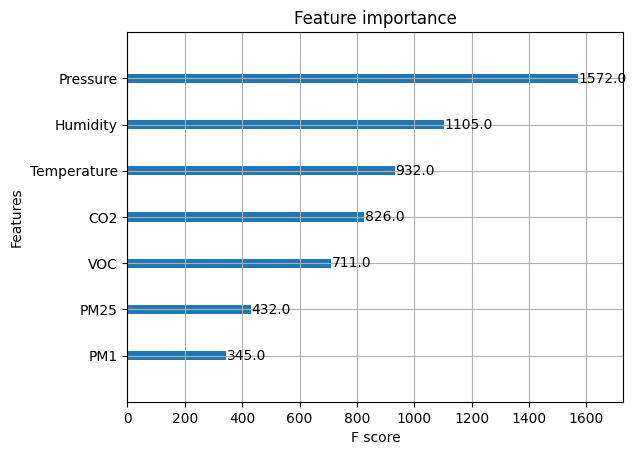

In [10]:
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(model, importance_type='weight')
plt.show()

C:\Users\Henry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


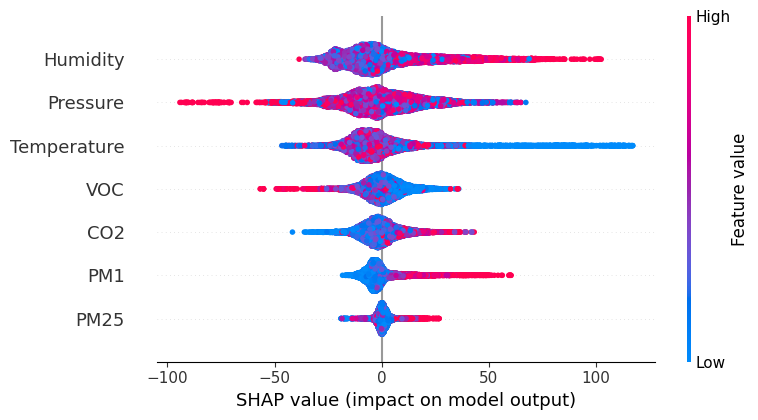

In [11]:
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot for feature impact
shap.summary_plot(shap_values, X_test)